# 010 - Sklearn DuckDB SQL Classification (CatBoost + XGBoost)

This notebook demonstrates **complete DuckDB SQL preprocessing** for classification with CatBoost (primary) and XGBoost (fallback).

## Key Features

| Aspect | Implementation |
|--------|---------------|
| **Primary Model** | CatBoost (best for categorical features, native handling) |
| **Fallback Model** | XGBoost (sklearn-native, full YellowBrick compatibility) |
| **SQL Preprocessing** | `DENSE_RANK() - 1` for all categoricals (universal compatibility) |
| **JSON extraction** | `json_extract_string()` in DuckDB SQL |
| **Timestamp parsing** | `date_part()` in DuckDB SQL |
| **Feature scaling** | None needed (tree-based models) |

## Model Comparison

| Aspect | CatBoost | XGBoost |
|--------|----------|---------|
| **Categorical handling** | Native via `cat_features` indices | Direct (label-encoded integers) |
| **Imbalanced data** | `auto_class_weights='Balanced'` | `scale_pos_weight` |
| **YellowBrick (data-only)** | ✅ All visualizers | ✅ All visualizers |
| **YellowBrick (estimator)** | ❌ FeatureImportances, RFECV | ✅ Full sklearn compatibility |

## Data Pipeline

```
Delta Lake → DuckDB SQL (DENSE_RANK encoding) → All-numeric DataFrame
                                                      ↓
                                    ┌─────────────────┼─────────────────┐
                                    ↓                 ↓                 ↓
                               CatBoost          XGBoost          YellowBrick
                            (cat_features)    (direct use)      (all numeric)
```

In [1]:
import duckdb
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from imblearn.metrics import geometric_mean_score
from catboost import CatBoostClassifier  # Primary model - best for categorical features
from xgboost import XGBClassifier  # Fallback model - sklearn-native for YellowBrick testing
from pprint import pprint
import yellowbrick
from yellowbrick import features  # Feature analysis visualizers
import matplotlib.pyplot as plt

In [2]:
MINIO_HOST = "localhost"
MINIO_PORT = "9000"
MINIO_ENDPOINT = f"{MINIO_HOST}:{MINIO_PORT}"
MINIO_ACCESS_KEY = "minioadmin"
MINIO_SECRET_KEY = "minioadmin123"
PROJECT_NAME = "Transaction Fraud Detection"

In [3]:
DELTA_PATHS = {
    "Transaction Fraud Detection": "s3://lakehouse/delta/transaction_fraud_detection",
    "Estimated Time of Arrival": "s3://lakehouse/delta/estimated_time_of_arrival",
    "E-Commerce Customer Interactions": "s3://lakehouse/delta/e_commerce_customer_interactions",
}

delta_path = DELTA_PATHS.get(PROJECT_NAME)

In [4]:
# Disable AWS EC2 metadata service lookup (prevents 169.254.169.254 errors)
os.environ["AWS_EC2_METADATA_DISABLED"] = "true"

# Create connection (in-memory database)
conn = duckdb.connect()

# Install and load required extensions
conn.execute("INSTALL delta; LOAD delta;")
conn.execute("INSTALL httpfs; LOAD httpfs;")

# Create a secret for S3/MinIO credentials
conn.execute(f"""
    CREATE SECRET minio_secret (
        TYPE S3,
        KEY_ID '{MINIO_ACCESS_KEY}',
        SECRET '{MINIO_SECRET_KEY}',
        REGION 'us-east-1',
        ENDPOINT '{MINIO_ENDPOINT}',
        URL_STYLE 'path',
        USE_SSL false
    );
""")
print("DuckDB extensions loaded and S3 secret configured")

DuckDB extensions loaded and S3 secret configured


## Feature Definitions

Define features upfront for CatBoost's native categorical handling.

In [5]:
# Feature definitions for Transaction Fraud Detection
TFD_NUMERICAL_FEATURES = [
    "amount",
    "account_age_days",
    "cvv_provided",
    "billing_address_match",
]

TFD_CATEGORICAL_FEATURES = [
    "currency",
    "merchant_id",
    "payment_method",
    "product_category",
    "transaction_type",
    "browser",
    "os",
    "year",
    "month",
    "day",
    "hour",
    "minute",
    "second",
]

TFD_ALL_FEATURES = TFD_NUMERICAL_FEATURES + TFD_CATEGORICAL_FEATURES

# Categorical feature indices for CatBoost (position in feature list)
TFD_CAT_FEATURE_INDICES = list(range(
    len(TFD_NUMERICAL_FEATURES),
    len(TFD_ALL_FEATURES)
))

print(f"Numerical features: {len(TFD_NUMERICAL_FEATURES)}")
print(f"Categorical features: {len(TFD_CATEGORICAL_FEATURES)}")
print(f"Categorical indices: {TFD_CAT_FEATURE_INDICES}")

Numerical features: 4
Categorical features: 13
Categorical indices: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


## DuckDB SQL Preprocessing

All categorical features are **label-encoded in SQL** using `DENSE_RANK() - 1`:

```sql
SELECT
    -- Numerical features (unchanged)
    amount, account_age_days, ...
    
    -- Categorical features: Label encoded (0-indexed integers)
    DENSE_RANK() OVER (ORDER BY currency) - 1 AS currency,
    DENSE_RANK() OVER (ORDER BY merchant_id) - 1 AS merchant_id,
    ...
FROM delta_scan('s3://...')
```

### Why Label Encoding in SQL?

| Benefit | Description |
|---------|-------------|
| **Universal compatibility** | Works with CatBoost, XGBoost, YellowBrick, sklearn |
| **CatBoost native handling** | Pass `cat_features` indices - CatBoost treats integers as categoricals |
| **XGBoost direct use** | No additional encoding needed |
| **YellowBrick ready** | Requires all numeric data - no Python conversion needed |
| **Single query** | One SQL query for all use cases |

In [6]:
def load_data_duckdb_sql(
    delta_path: str,
    sample_frac: float | None = None,
    max_rows: int | None = None,
) -> pd.DataFrame:
    """
    Load and preprocess data using pure DuckDB SQL.
    
    All categorical features are label-encoded using DENSE_RANK() - 1.
    This produces numeric data compatible with:
    - CatBoost (pass cat_features indices for native handling)
    - XGBoost (works directly with integers)
    - YellowBrick (requires numeric data)
    - All sklearn tools
    
    Args:
        delta_path: Path to Delta Lake table
        sample_frac: Optional fraction of data to sample (0.0-1.0)
        max_rows: Optional maximum number of rows to load
    
    Returns:
        DataFrame with preprocessed features (all numeric) and target
    """
    # Single query: All features numeric, categoricals label-encoded
    query = f"""
    SELECT
        -- Numerical features (unchanged)
        amount,
        account_age_days,
        CAST(cvv_provided AS INTEGER) AS cvv_provided,
        CAST(billing_address_match AS INTEGER) AS billing_address_match,

        -- Categorical features: Label encoded with DENSE_RANK() - 1
        -- This produces 0-indexed integers compatible with all ML tools
        DENSE_RANK() OVER (ORDER BY currency) - 1 AS currency,
        DENSE_RANK() OVER (ORDER BY merchant_id) - 1 AS merchant_id,
        DENSE_RANK() OVER (ORDER BY payment_method) - 1 AS payment_method,
        DENSE_RANK() OVER (ORDER BY product_category) - 1 AS product_category,
        DENSE_RANK() OVER (ORDER BY transaction_type) - 1 AS transaction_type,
        
        -- JSON extraction + Label encoded
        DENSE_RANK() OVER (ORDER BY json_extract_string(device_info, '$.browser')) - 1 AS browser,
        DENSE_RANK() OVER (ORDER BY json_extract_string(device_info, '$.os')) - 1 AS os,

        -- Timestamp components (already integers)
        CAST(date_part('year', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS year,
        CAST(date_part('month', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS month,
        CAST(date_part('day', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS day,
        CAST(date_part('hour', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS hour,
        CAST(date_part('minute', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS minute,
        CAST(date_part('second', CAST(timestamp AS TIMESTAMP)) AS INTEGER) AS second,

        -- Target
        is_fraud

    FROM delta_scan('{delta_path}')
    """
    
    print(f"Loading data with DuckDB SQL (all features numeric)...")

    # Add sampling clause
    if sample_frac is not None and 0 < sample_frac < 1:
        query += f" USING SAMPLE {sample_frac * 100}%"
        print(f"  Sampling: {sample_frac * 100}%")

    # Add limit clause
    if max_rows is not None:
        query += f" LIMIT {max_rows}"
        print(f"  Max rows: {max_rows}")

    df = conn.execute(query).df()
    print(f"  Loaded {len(df):,} rows with {len(df.columns)} columns")
    print(f"  All features numeric: {df.select_dtypes(include=['number']).shape[1]}/{len(df.columns)} columns")
    
    return df

In [7]:
# Set model type for training (both use same numeric data now)
MODEL_TYPE = "catboost"  # "catboost" (primary) or "xgboost" (fallback for YellowBrick)

# Load data - always numeric, compatible with all tools
df = load_data_duckdb_sql(delta_path, max_rows=10000)
df.head()

Loading data with DuckDB SQL (all features numeric)...
  Max rows: 10000


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Loaded 10,000 rows with 18 columns
  All features numeric: 18/18 columns


,amount,account_age_days,cvv_provided,billing_address_match,currency,merchant_id,payment_method,product_category,transaction_type,browser,os,year,month,day,hour,minute,second,is_fraud
0,144.11,609,1,1,5,174,3,4,0,5,0,2026,1,15,13,36,14,0
1,409.65,1475,1,1,1,175,3,4,0,5,0,2026,1,14,21,6,4,0
2,420.20,891,1,1,1,176,3,4,0,5,0,2026,1,15,10,19,12,0
3,51.75,311,1,1,2,167,3,4,0,5,0,2026,1,18,18,31,20,0
4,254.99,384,1,1,2,158,3,4,0,5,0,2026,1,15,5,41,30,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount                 10000 non-null  float64
 1   account_age_days       10000 non-null  int32  
 2   cvv_provided           10000 non-null  int32  
 3   billing_address_match  10000 non-null  int32  
 4   currency               10000 non-null  int64  
 5   merchant_id            10000 non-null  int64  
 6   payment_method         10000 non-null  int64  
 7   product_category       10000 non-null  int64  
 8   transaction_type       10000 non-null  int64  
 9   browser                10000 non-null  int64  
 10  os                     10000 non-null  int64  
 11  year                   10000 non-null  int32  
 12  month                  10000 non-null  int32  
 13  day                    10000 non-null  int32  
 14  hour                   10000 non-null  int32  
 15  min

## Process Batch Data

Split features/target and prepare for training.

Data is **already all-numeric** from DuckDB SQL:
- Numerical features: unchanged (amount, account_age_days, etc.)
- Categorical features: label-encoded as 0-indexed integers
- Timestamp components: extracted as integers (year, month, day, etc.)

Works with both models:
- **CatBoost**: Pass `cat_features=TFD_CAT_FEATURE_INDICES` for native categorical handling
- **XGBoost**: Use directly - all features already numeric

In [9]:
def process_batch_data_duckdb(
    df: pd.DataFrame,
    test_size: float = 0.2,
    random_state: int = 42,
):
    """
    Process batch data for model training.
    
    Data is already all-numeric from load_data_duckdb_sql().
    Works with both CatBoost (pass cat_features indices) and XGBoost.
    
    Args:
        df: DataFrame from load_data_duckdb_sql() (all numeric)
        test_size: Fraction for test set
        random_state: Random seed
    
    Returns:
        X_train, X_test, y_train, y_test
    """
    # Split features and target
    y = df["is_fraud"]
    X = df.drop("is_fraud", axis=1)
    
    print(f"Features: {len(X.columns)} total ({len(TFD_NUMERICAL_FEATURES)} numeric, {len(TFD_CATEGORICAL_FEATURES)} label-encoded)")
    print(f"All features are numeric - compatible with YellowBrick and sklearn tools")
    
    # Stratified train/test split (keeps class balance)
    print(f"Splitting data: {1-test_size:.0%} train, {test_size:.0%} test (stratified)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state,
    )
    
    print(f"  Training set: {len(X_train):,} samples")
    print(f"  Test set: {len(X_test):,} samples")
    
    # Calculate class balance
    fraud_rate = y_train.sum() / len(y_train) * 100
    print(f"  Fraud rate in training set: {fraud_rate:.2f}%")
    
    return X_train, X_test, y_train, y_test

In [10]:
# Process data - same for both model types (data is already numeric)
X_train, X_test, y_train, y_test = process_batch_data_duckdb(df)

Features: 17 total (4 numeric, 13 label-encoded)
All features are numeric - compatible with YellowBrick and sklearn tools
Splitting data: 80% train, 20% test (stratified)...
  Training set: 8,000 samples
  Test set: 2,000 samples
  Fraud rate in training set: 1.21%


In [11]:
X_train.head()

,amount,account_age_days,cvv_provided,billing_address_match,currency,merchant_id,payment_method,product_category,transaction_type,browser,os,year,month,day,hour,minute,second
8050,124.72,866,1,1,1,129,2,5,2,5,0,2026,1,15,12,52,55
3697,463.67,43,1,1,4,164,3,1,1,5,0,2026,1,14,1,37,43
8518,256.95,1239,1,1,1,16,1,4,2,5,0,2026,1,13,0,25,22
3732,218.27,1469,1,1,0,59,4,1,1,5,0,2026,1,17,2,37,18
7511,363.22,347,1,1,5,167,4,8,2,5,0,2026,1,16,23,1,2


In [12]:
X_train.dtypes

amount                   float64
account_age_days           int32
cvv_provided               int32
billing_address_match      int32
currency                   int64
merchant_id                int64
payment_method             int64
product_category           int64
transaction_type           int64
browser                    int64
os                         int64
year                       int32
month                      int32
day                        int32
hour                       int32
minute                     int32
second                     int32
dtype: object

## Model Creation (CatBoost Primary, XGBoost Fallback)

### CatBoost (Primary)
Optimal for fraud detection with categorical features:
- **Native categorical handling** - no encoding needed (but we encode in SQL for uniformity)
- **`auto_class_weights='Balanced'`** - handles class imbalance automatically
- **Built-in regularization** - L2 leaf regularization, early stopping

### XGBoost (Fallback for YellowBrick)
sklearn-native, useful for testing YellowBrick visualizations:
- **`scale_pos_weight`** - handles class imbalance (neg/pos ratio)
- **sklearn BaseEstimator** - full compatibility with sklearn ecosystem
- **Fast histogram-based** - efficient training on large datasets

### Optimized Parameters

Based on [CatBoost docs](https://catboost.ai/docs/en/references/training-parameters/common) and [fraud detection research](https://www.preprints.org/manuscript/202503.1199):

| Parameter | CatBoost | XGBoost |
|-----------|----------|---------|
| **Iterations** | 1000 | 500 |
| **Learning Rate** | 0.05 | 0.1 |
| **Depth** | 6 | 6 |
| **Regularization** | l2_leaf_reg=3 | reg_alpha=0.1, reg_lambda=1.0 |
| **Imbalance** | auto_class_weights='Balanced' | scale_pos_weight |
| **Boosting Type** | Plain (1M+ rows) | hist |
| **Early Stopping** | 50 rounds | 50 rounds |

**Note**: `boosting_type='Plain'` is recommended for large datasets (1M+ rows). Use `'Ordered'` for smaller datasets (<100K rows).

In [13]:
from typing import Literal

def create_batch_model(
    model_type: Literal["catboost", "xgboost"] = "catboost",
    y_train=None,
    cat_feature_indices: list[int] | None = None,
):
    """
    Create classifier optimized for fraud detection.
    
    Args:
        model_type: "catboost" (primary) or "xgboost" (fallback for YellowBrick)
        y_train: Training labels for calculating class imbalance ratio
        cat_feature_indices: Indices of categorical features (for CatBoost)
    
    Returns:
        Configured classifier ready for training
    
    References:
        - CatBoost docs: https://catboost.ai/docs/en/references/training-parameters/common
        - Fraud detection research: CatBoost achieves F1=0.92, AUC=0.99
    """
    # Calculate class imbalance ratio
    scale_pos_weight = 1.0
    if y_train is not None:
        neg_samples = sum(y_train == 0)
        pos_samples = sum(y_train == 1)
        if pos_samples > 0:
            scale_pos_weight = neg_samples / pos_samples
        print(f"Class imbalance ratio: {scale_pos_weight:.2f}:1 (negative:positive)")
        print(f"Fraud rate: {pos_samples / len(y_train) * 100:.2f}%")
    
    if model_type == "catboost":
        print(f"Creating CatBoostClassifier (primary model)")
        print(f"  Using auto_class_weights='Balanced' for imbalanced data")
        if cat_feature_indices:
            print(f"  Categorical feature indices: {cat_feature_indices}")
        
        # Optimized CatBoost parameters for fraud detection (1M+ rows, ~1% fraud)
        model = CatBoostClassifier(
            # Core parameters
            iterations=1000,                # Max trees; early stopping finds optimal
            learning_rate=0.05,             # Good balance for 1M+ rows
            depth=6,                        # CatBoost default, good for most cases
            
            # Imbalanced data handling (critical for fraud detection)
            auto_class_weights='Balanced',  # Weights positive class by neg/pos ratio
            
            # Loss function & evaluation
            loss_function='Logloss',        # Binary cross-entropy
            eval_metric='AUC',              # Best for imbalanced binary classification
            
            # Regularization
            l2_leaf_reg=3,                  # L2 regularization (default=3)
            
            # Boosting type: 'Plain' for large datasets (1M+), 'Ordered' for <100K
            boosting_type='Plain',
            
            # Early stopping
            early_stopping_rounds=50,
            
            # Performance
            task_type='CPU',
            thread_count=-1,                # Use all CPU cores
            random_seed=42,
            
            # Output
            verbose=True,
        )
    
    elif model_type == "xgboost":
        print(f"Creating XGBClassifier (fallback for YellowBrick testing)")
        print(f"  Using scale_pos_weight={scale_pos_weight:.2f}")
        
        model = XGBClassifier(
            # Core parameters
            n_estimators=500,
            learning_rate=0.1,
            max_depth=6,
            
            # Imbalanced data handling
            scale_pos_weight=scale_pos_weight,
            
            # Regularization (prevent overfitting)
            min_child_weight=1,
            gamma=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,  # L1 regularization
            reg_lambda=1.0,  # L2 regularization
            
            # Training settings
            objective='binary:logistic',
            eval_metric='auc',
            
            # Early stopping
            early_stopping_rounds=50,
            
            # Performance
            tree_method='hist',
            n_jobs=-1,
            random_state=42,
        )
    
    else:
        raise ValueError(f"Unknown model_type: {model_type}. Use 'catboost' or 'xgboost'.")
    
    return model

In [14]:
# Create model using MODEL_TYPE defined earlier (determines both query and model)
model = create_batch_model(
    model_type=MODEL_TYPE,
    y_train=y_train,
    cat_feature_indices=TFD_CAT_FEATURE_INDICES,
)

Class imbalance ratio: 81.47:1 (negative:positive)
Fraud rate: 1.21%
Creating CatBoostClassifier (primary model)
  Using auto_class_weights='Balanced' for imbalanced data
  Categorical feature indices: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


## Train Model

Training with all-numeric features (label-encoded in DuckDB SQL).

**CatBoost**: Pass `cat_features` indices - CatBoost recognizes these integer columns as categoricals and applies optimal encoding (target statistics, one-hot, etc.)

**XGBoost**: All features already numeric - no special handling needed.

In [15]:
# Train model based on type
if MODEL_TYPE == "catboost":
    # CatBoost training with native categorical handling
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        cat_features=TFD_CAT_FEATURE_INDICES,  # Optional: CatBoost handles encoded cats too
        use_best_model=True,
        verbose=True,
    )
else:
    # XGBoost training
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=True,
    )

print(f"\n{MODEL_TYPE.upper()} training complete!")

0:	test: 0.8930499	best: 0.8930499 (0)	total: 75.7ms	remaining: 1m 15s
1:	test: 0.8928391	best: 0.8930499 (0)	total: 111ms	remaining: 55.2s
2:	test: 0.9916393	best: 0.9916393 (2)	total: 181ms	remaining: 1m
3:	test: 0.9927674	best: 0.9927674 (3)	total: 231ms	remaining: 57.6s
4:	test: 0.9938112	best: 0.9938112 (4)	total: 291ms	remaining: 57.9s
5:	test: 0.9936214	best: 0.9938112 (4)	total: 344ms	remaining: 57s
6:	test: 0.9931364	best: 0.9938112 (4)	total: 407ms	remaining: 57.7s
7:	test: 0.9931996	best: 0.9938112 (4)	total: 482ms	remaining: 59.8s
8:	test: 0.9931153	best: 0.9938112 (4)	total: 538ms	remaining: 59.2s
9:	test: 0.9939588	best: 0.9939588 (9)	total: 583ms	remaining: 57.7s
10:	test: 0.9954137	best: 0.9954137 (10)	total: 624ms	remaining: 56.1s
11:	test: 0.9958882	best: 0.9958882 (11)	total: 708ms	remaining: 58.3s
12:	test: 0.9958460	best: 0.9958882 (11)	total: 840ms	remaining: 1m 3s
13:	test: 0.9952556	best: 0.9958882 (11)	total: 950ms	remaining: 1m 6s
14:	test: 0.9960674	best: 0.9

## Evaluate Model

In [16]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

## Model Comparison

Compare CatBoost (primary) vs XGBoost (fallback) on this dataset.

Run the notebook twice with `MODEL_TYPE = "catboost"` and `MODEL_TYPE = "xgboost"` to compare.

| Metric | CatBoost | XGBoost | Winner |
|--------|----------|---------|--------|
| Accuracy | ? | ? | ? |
| Precision | ? | ? | ? |
| Recall | ? | ? | ? |
| F1 | ? | ? | ? |
| ROCAUC | ? | ? | ? |
| GeometricMean | ? | ? | ? |

**Key Differences:**
- **CatBoost**: Native categorical handling, ordered boosting, auto class weights
- **XGBoost**: sklearn-native, compatible with YellowBrick visualizations

In [17]:
# -----------------------------------------------------------------------------
# PRIMARY METRICS - Class-based metrics for fraud detection
# These use y_pred (predicted labels), not probabilities
# -----------------------------------------------------------------------------
primary_metric_functions = {
    # Recall: Fraud detection rate (minimize missed fraud)
    # TP / (TP + FN) - How many actual frauds did we catch?
    "recall_score": metrics.recall_score,
    # Precision: False alarm rate (customer experience)
    # TP / (TP + FP) - Of predicted frauds, how many were actually fraud?
    "precision_score": metrics.precision_score,
    # F1: Harmonic mean of Precision & Recall
    # Best when you want balance between precision and recall
    "f1_score": metrics.f1_score,
    # F-beta with beta=2: Weights Recall 2x more than Precision
    # CRITICAL for fraud detection where missing fraud is costly
    "fbeta_score": metrics.fbeta_score,
}
primary_metric_args = {
    "recall_score": {
        "pos_label": 1,
        "average": "binary",
        "zero_division": 0.0,
    },
    "precision_score": {
        "pos_label": 1,
        "average": "binary",
        "zero_division": 0.0,
    },
    "f1_score": {
        "pos_label": 1,
        "average": "binary",
        "zero_division": 0.0,
    },
    "fbeta_score": {
        "beta": 2.0,
        "pos_label": 1,
        "average": "binary",
        "zero_division": 0.0,
    },
}

In [18]:
# -----------------------------------------------------------------------------
# SECONDARY METRICS - Good for monitoring and additional insights
# These provide complementary information but shouldn't drive model selection
# -----------------------------------------------------------------------------
secondary_metric_functions = {
    # Accuracy: Overall correctness (TP + TN) / Total
    # CAUTION: Misleading for imbalanced data when used alone!
    # Include for: baseline comparison, sanity checks, stakeholder reporting
    # With 3% fraud: predicting all non-fraud = 97% accuracy (useless!)
    # ALWAYS show alongside balanced_accuracy and recall
    "accuracy_score": metrics.accuracy_score,
    # Balanced Accuracy: Average of recall on each class
    # = (TPR + TNR) / 2 = (Recall_fraud + Recall_non_fraud) / 2
    # Better than accuracy for imbalanced data - penalizes ignoring minority
    "balanced_accuracy_score": metrics.balanced_accuracy_score,
    # Matthews Correlation Coefficient: Most robust single metric
    # Balanced measure, works well with imbalanced classes
    # Range: [-1, +1], 0 = random, +1 = perfect, -1 = inverse
    # Only metric that gives high score when all 4 confusion matrix categories are good
    "matthews_corrcoef": metrics.matthews_corrcoef,
    # Cohen's Kappa: Agreement beyond chance
    # Useful for comparing with baseline/random classifier
    # Range: [-1, +1], 0 = no better than chance, +1 = perfect
    "cohen_kappa_score": metrics.cohen_kappa_score,
    # Jaccard Score: Intersection over Union (IoU)
    # TP / (TP + FP + FN) - stricter than F1
    # Ignores TN, focuses only on positive class predictions
    "jaccard_score": metrics.jaccard_score,
}
secondary_metric_args = {
    # Accuracy: normalize=True returns fraction [0, 1]
    # sample_weight=None means equal weight for all samples
    # For imbalanced data: use alongside balanced_accuracy, never alone!
    "accuracy_score": {
        "normalize": True,  # Return fraction (0.0 to 1.0), not count
        # sample_weight: Can be set dynamically to correct for imbalance
        # Example: weight fraud samples higher to penalize missing them
    },
    # Balanced Accuracy: adjusted=False returns [0, 1], adjusted=True shifts to [-0.5, 1]
    # adjusted=True: random classifier scores 0, adjusted=False: random scores ~0.5
    "balanced_accuracy_score": {
        "adjusted": False,  # Keep in [0, 1] range for interpretability
    },
    # MCC: No special args, works on y_true vs y_pred
    # Handles imbalanced data well by design
    "matthews_corrcoef": {},
    # Cohen's Kappa: weights=None for unweighted agreement
    # weights='linear' or 'quadratic' for ordinal classification
    "cohen_kappa_score": {
        "weights": None,  # Unweighted (linear/quadratic for ordinal data)
    },
    # Jaccard: binary classification with fraud as positive class
    "jaccard_score": {
        "pos_label": 1,
        "average": "binary",
        "zero_division": 0.0,
    },
}

In [19]:
# -----------------------------------------------------------------------------
# PROBABILISTIC METRICS - Use y_pred_proba (probability scores)
# These measure ranking ability and probability calibration
# -----------------------------------------------------------------------------
probabilistic_metric_functions = {
    # ROC-AUC: Best overall threshold-independent metric for imbalanced binary
    # Area under ROC curve, measures ranking ability
    "roc_auc_score": metrics.roc_auc_score,
    # Average Precision (PR-AUC): Area under precision-recall curve
    # Better than ROC-AUC for highly imbalanced data
    "average_precision_score": metrics.average_precision_score,
    # Log Loss (Cross-Entropy): Penalizes confident wrong predictions
    # Lower is better, heavily penalizes confident mistakes
    "log_loss": metrics.log_loss,
    # Brier Score: Mean squared error of probability predictions
    # Lower is better, range [0, 1]
    "brier_score_loss": metrics.brier_score_loss,
    # D^2 Log Loss Score: Fraction of log loss explained
    # Similar to R^2, but for log loss; higher is better
    "d2_log_loss_score": metrics.d2_log_loss_score,
    # D^2 Brier Score: Fraction of Brier score explained
    # Similar to R^2, but for Brier score; higher is better
    "d2_brier_score": metrics.d2_brier_score,
}
probabilistic_metric_args = {
    "roc_auc_score": {},
    "average_precision_score": {
        "pos_label": 1,
    },
    "log_loss": {
        "normalize": True,
    },
    "brier_score_loss": {
        "pos_label": 1,
    },
    "d2_log_loss_score": {},
    "d2_brier_score": {
        "pos_label": 1,
    },
}

In [20]:
# -----------------------------------------------------------------------------
# ANALYSIS/REPORTING METRICS - For detailed analysis and threshold tuning
# These return multiple values or structured outputs
# -----------------------------------------------------------------------------
analysis_metric_functions = {
    # Confusion Matrix: Foundation for many other metrics
    # Returns 2x2 matrix: [[TN, FP], [FN, TP]]
    "confusion_matrix": metrics.confusion_matrix,
    # NEW IN SKLEARN 1.8! Confusion Matrix at Thresholds
    # Returns TN, FP, FN, TP arrays for each threshold
    # CRITICAL for threshold optimization in fraud detection
    "confusion_matrix_at_thresholds": metrics.confusion_matrix_at_thresholds,
    # Classification Report: Text summary of P, R, F1 per class
    # Can return dict with output_dict=True
    "classification_report": metrics.classification_report,
    # Precision-Recall Curve: For threshold analysis
    # Returns (precision, recall, thresholds)
    "precision_recall_curve": metrics.precision_recall_curve,
    # ROC Curve: For threshold analysis
    # Returns (fpr, tpr, thresholds)
    "roc_curve": metrics.roc_curve,
    # DET Curve: Detection Error Tradeoff
    # Returns (fpr, fnr, thresholds) - plots FNR vs FPR
    # Useful for fraud: visualize false alarm vs missed fraud tradeoff
    "det_curve": metrics.det_curve,
    # Class Likelihood Ratios: LR+, LR- for diagnostic testing
    # Returns (positive_lr, negative_lr)
    "class_likelihood_ratios": metrics.class_likelihood_ratios,
    # Precision-Recall-FScore-Support: All in one
    # Returns (precision, recall, fbeta, support) arrays
    "precision_recall_fscore_support": metrics.precision_recall_fscore_support,
    # AUC: General utility to compute area under any curve
    "auc": metrics.auc,
}
analysis_metric_args = {
    # Confusion Matrix: labels=[0, 1] ensures consistent ordering
    # normalize='true' normalizes over actual (row-wise)
    "confusion_matrix": {
        "labels": [0, 1],  # [non-fraud, fraud]
        "normalize": None,  # Return raw counts; use 'true'/'pred'/'all' for proportions
    },
    # Confusion Matrix at Thresholds: pos_label=1 for fraud
    # Returns (tns, fps, fns, tps, thresholds) arrays
    "confusion_matrix_at_thresholds": {
        "pos_label": 1,  # Fraud is positive class
    },
    # Classification Report: output_dict=True for programmatic access
    "classification_report": {
        "target_names": ["Non-Fraud", "Fraud"],
        "output_dict": True,  # Return dict instead of string
        "zero_division": 0.0,
    },
    # Precision-Recall Curve: pos_label=1 for fraud class
    "precision_recall_curve": {
        "pos_label": 1,
    },
    # ROC Curve: pos_label=1 for fraud class
    "roc_curve": {
        "pos_label": 1,
        "drop_intermediate": True,  # Reduce points for efficiency
    },
    # DET Curve: pos_label=1 for fraud class
    "det_curve": {
        "pos_label": 1,
        "drop_intermediate": True,  # Reduce points for efficiency
    },
    # Class Likelihood Ratios: labels=[non-fraud, fraud] ordering
    "class_likelihood_ratios": {
        "labels": [0, 1],  # [negative_class, positive_class]
    },
    # Precision-Recall-FScore-Support: beta=1.0 for F1
    "precision_recall_fscore_support": {
        "beta": 1.0,
        "pos_label": 1,
        "average": "binary",
        "zero_division": 0.0,
    },
    # AUC: No default args, takes x and y arrays directly
    "auc": {},
}

## Comprehensive Metrics Evaluation

Sklearn metrics organized following River ML structure for consistency:

| Category | River (Online) | Sklearn (Batch) |
|----------|----------------|-----------------|
| **Class-based** | `.update(y, pred)` | `func(y_true, y_pred)` |
| **Probability-based** | `.update(y, proba)` | `func(y_true, y_proba)` |
| **Report/Matrix** | `.update(y, pred)` | `func(y_true, y_pred)` |

Key difference: River metrics are incremental (`.update()`), sklearn are batch functions.

In [21]:
# =============================================================================
# COMPUTE ALL METRICS
# =============================================================================
metrics_to_log = {}

# -----------------------------------------------------------------------------
# PRIMARY METRICS (class-based, use y_pred)
# -----------------------------------------------------------------------------
for name, func in primary_metric_functions.items():
    metrics_to_log[name] = func(y_test, y_pred, **primary_metric_args[name])

# -----------------------------------------------------------------------------
# SECONDARY METRICS (class-based, use y_pred)
# -----------------------------------------------------------------------------
for name, func in secondary_metric_functions.items():
    metrics_to_log[name] = func(y_test, y_pred, **secondary_metric_args[name])

# -----------------------------------------------------------------------------
# PROBABILISTIC METRICS (use y_pred_proba)
# -----------------------------------------------------------------------------
for name, func in probabilistic_metric_functions.items():
    metrics_to_log[name] = func(y_test, y_pred_proba, **probabilistic_metric_args[name])

metrics_to_log

{'recall_score': 0.9583333333333334,
 'precision_score': 0.5476190476190477,
 'f1_score': 0.696969696969697,
 'fbeta_score': 0.8333333333333334,
 'accuracy_score': 0.99,
 'balanced_accuracy_score': 0.9743589743589745,
 'matthews_corrcoef': 0.7204522783249563,
 'cohen_kappa_score': 0.6922698178237321,
 'jaccard_score': 0.5348837209302325,
 'roc_auc_score': 0.9989667678812415,
 'average_precision_score': 0.9491382809593072,
 'log_loss': 0.13279809959671962,
 'brier_score_loss': 0.026949360136081495,
 'd2_log_loss_score': -1.0429881625498658,
 'd2_brier_score': -1.2730566916398018}

In [22]:
# Display report metrics (ConfusionMatrix, ClassificationReport)
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred, **analysis_metric_args["confusion_matrix"]))
print("\nClassification Report:")
print(metrics.classification_report(
    y_test, y_pred, 
    target_names=["Non-Fraud", "Fraud"],
    zero_division=0.0
))

Confusion Matrix:
[[1957   19]
 [   1   23]]

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.99      0.99      1976
       Fraud       0.55      0.96      0.70        24

    accuracy                           0.99      2000
   macro avg       0.77      0.97      0.85      2000
weighted avg       0.99      0.99      0.99      2000



In [23]:
# Print all model parameters
print("\nModel parameters:")
all_params = model.get_all_params()
for param_name, param_value in all_params.items():
    print(f"  {param_name}: {param_value}")


Model parameters:
  nan_mode: Min
  eval_metric: AUC
  combinations_ctr: ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
  iterations: 1000
  sampling_frequency: PerTree
  fold_permutation_block: 0
  leaf_estimation_method: Newton
  od_pval: 0
  random_score_type: NormalWithModelSizeDecrease
  counter_calc_method: SkipTest
  grow_policy: SymmetricTree
  penalties_coefficient: 1
  boosting_type: Plain
  model_shrink_mode: Constant
  feature_border_type: GreedyLogSum
  ctr_leaf_count_limit: 18446744073709551615
  bayesian_matrix_reg: 0.10000000149011612
  one_hot_max_size: 2
  eval_fraction: 0
  force_unit_auto_pair_weights: False
  l2_leaf_reg: 3
  random_strength: 1
  od_type: Iter
  rsm: 1
  boost_from_average: False
  max_ctr_complexity: 4
  model_size_reg: 0.5
  simple_ctr: ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCoun

# YellowBrick

## Features Visualization

In [35]:
def yellowbrick_feature_analysis_kwargs(
    classes,
    features=None,
    estimator=None,
    cv=None,
    verbose=True
):
    """
    Generate kwargs for ALL yellowbrick.features visualizers.
    
    Reference: https://www.scikit-yb.org/en/latest/api/features/index.html

    Parameters:
    -----------
    classes : list
        List of class labels [0, 1] for binary classification
    features : list, optional
        List of feature names (default: None, auto-detected)
    estimator : sklearn estimator, optional
        Required for FeatureImportances/RFECV (default: None, skips these)
        Note: CatBoost is NOT sklearn-compatible, only XGBoost works
    cv : cross-validator, optional
        Cross-validation strategy for RFECV (default: None uses StratifiedKFold)
    verbose : bool
        Print configuration details (default: True)

    Returns:
    --------
    dict : Dictionary of visualizer name -> kwargs
    
    YellowBrick Feature Visualizers (from official docs):
    -----------------------------------------------------
    | Visualizer          | Fit Method      | CatBoost | XGBoost |
    |---------------------|-----------------|----------|---------|
    | Rank1D              | fit + transform | ✓        | ✓       |
    | Rank2D              | fit + transform | ✓        | ✓       |
    | PCA                 | fit_transform   | ✓        | ✓       |
    | Manifold            | fit_transform   | ✓        | ✓       |
    | ParallelCoordinates | fit_transform   | ✓        | ✓       |
    | RadViz              | fit + transform | ✓        | ✓       |
    | JointPlot           | fit             | ✓        | ✓       |
    | FeatureImportances  | fit             | ✗        | ✓       |
    | RFECV               | fit             | ✗        | ✓       |
    """
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Check if estimator is sklearn-compatible (CatBoost is NOT)
    is_sklearn_compatible = False
    estimator_name = "None"
    if estimator is not None:
        estimator_name = type(estimator).__name__
        is_sklearn_compatible = estimator_name in [
            "XGBClassifier", "XGBRegressor", 
            "RandomForestClassifier", "GradientBoostingClassifier"
        ]

    kwargs = {
        # =================================================================
        # RANK FEATURES - Detect covariance between features
        # Docs: https://www.scikit-yb.org/en/latest/api/features/rankd.html
        # =================================================================
        
        # Rank1D: Single feature ranking using Shapiro-Wilk normality test
        # Algorithms: 'shapiro' (only one available)
        "Rank1D": {
            "algorithm": "shapiro",
            "features": features,
            "orient": "h",  # 'h' horizontal, 'v' vertical
            "show_feature_names": True,
        },
        
        # Rank2D: Pairwise feature ranking (correlation matrix)
        # Algorithms: 'pearson', 'covariance', 'spearman', 'kendalltau'
        "Rank2D": {
            "algorithm": "pearson",
            "features": features,
            "colormap": "RdBu_r",
            "show_feature_names": True,
        },
        
        # =================================================================
        # PROJECTION - Reduce dimensionality for visualization
        # =================================================================
        
        # PCA: Principal Component Analysis projection
        # Docs: https://www.scikit-yb.org/en/latest/api/features/pca.html
        "PCA": {
            "scale": True,           # Scale data before PCA
            "projection": 2,         # 2D or 3D
            "proj_features": False,  # True for biplot (show feature vectors)
            "classes": classes,
            "alpha": 0.75,
            "heatmap": False,        # Show feature contribution heatmap
        },
        
        # Manifold: Non-linear dimensionality reduction
        # Docs: https://www.scikit-yb.org/en/latest/api/features/manifold.html
        # Algorithms: 'lle', 'ltsa', 'hessian', 'modified', 'isomap', 'mds', 'spectral', 'tsne'
        # TOO SLOW
        #"Manifold": {
        #    "manifold": "tsne",      # t-SNE for best visualization
        #    "n_neighbors": 10,       # For lle, isomap, ltsa, hessian (ignored by tsne, mds)
        #    "classes": classes,
        #    "projection": 2,
        #    "alpha": 0.75,
        #    "random_state": 42,
        #    "target_type": "discrete",  # 'discrete', 'continuous', 'auto'
        #},

        # =================================================================
        # MULTI-DIMENSIONAL VISUALIZATION
        # =================================================================
        
        # ParallelCoordinates: Each instance as a line across feature axes
        # Docs: https://www.scikit-yb.org/en/latest/api/features/pcoords.html
        # Normalize: 'minmax', 'standard', 'l1', 'l2', 'maxabs'
        "ParallelCoordinates": {
            "classes": classes,
            "features": features,
            "normalize": "minmax",
            "sample": 0.05,          # Sample 5% for performance
            "shuffle": True,
            "alpha": 0.3,
            "fast": True,            # Fast drawing mode
        },
        
        # RadViz: Radial visualization (features as points on circle)
        # Docs: https://www.scikit-yb.org/en/latest/api/features/radviz.html
        "RadViz": {
            "classes": classes,
            "features": features,
            "alpha": 0.5,
        },

        # =================================================================
        # DIRECT DATA VISUALIZATION
        # =================================================================
        
        # JointPlot: 2D correlation between two features
        # Docs: https://www.scikit-yb.org/en/latest/api/features/jointplot.html
        # columns: string (single feature) or list of two feature names
        # correlation: 'pearson', 'covariance', 'spearman', 'kendalltau'
        # kind: 'scatter', 'hex'
        "JointPlot": {
            "columns": features[:2] if features and len(features) >= 2 else None,
            "correlation": "pearson",
            "kind": "scatter",
            "hist": True,            # True, False, 'density', 'frequency'
            "alpha": 0.65,
        },
    }

    # =================================================================
    # ESTIMATOR-BASED VISUALIZERS (sklearn-compatible only!)
    # CatBoost does NOT work - use XGBoost for these
    # =================================================================
    if estimator is not None and is_sklearn_compatible:
        kwargs["FeatureImportances"] = {
            "estimator": estimator,
            "labels": features,
            "relative": True,
            "absolute": False,
            "stack": False,
            "topn": None,
        }
        # RFECV: Very slow - uncomment if needed
        # kwargs["RFECV"] = {
        #     "estimator": estimator,
        #     "cv": cv,
        #     "scoring": "average_precision",
        #     "step": 1,
        # }

    if verbose:
        print()
        print("+" + "=" * 72 + "+")
        print("|" + " YELLOWBRICK FEATURE ANALYSIS CONFIGURATION ".center(72) + "|")
        print("+" + "=" * 72 + "+")
        print(f"| {'Classes:':<20} {str(classes):<50} |")
        print(f"| {'Features:':<20} {(str(len(features)) + ' features') if features else 'auto-detect':<50} |")
        print(f"| {'Estimator:':<20} {estimator_name:<50} |")
        print(f"| {'Sklearn-compatible:':<20} {'Yes' if is_sklearn_compatible else 'No (estimator visualizers skipped)':<50} |")
        print("+" + "-" * 72 + "+")
        print(f"| {'Configured ' + str(len(kwargs)) + ' visualizers:':<72} |")
        print("+" + "-" * 72 + "+")
        
        for i, (name, params) in enumerate(kwargs.items(), 1):
            if name in ["FeatureImportances", "RFECV"]:
                vtype = "ESTIMATOR"
            elif name in ["Manifold"]:
                algo = params.get("manifold", "mds").upper()
                vtype = f"PROJECTION ({algo})"
            elif name in ["PCA"]:
                vtype = "PROJECTION (PCA)"
            elif name in ["Rank1D", "Rank2D"]:
                algo = params.get("algorithm", "").upper()
                vtype = f"RANKING ({algo})"
            else:
                vtype = "DATA-ONLY"
            print(f"|   {i:>2}. {name:<25} [{vtype:<20}] |")
        
        if estimator is not None and not is_sklearn_compatible:
            print("+" + "-" * 72 + "+")
            print(f"| {'WARNING: ' + estimator_name + ' is not sklearn-compatible.':<72} |")
            print(f"| {'FeatureImportances/RFECV require XGBoost or sklearn estimators.':<72} |")
        
        print("+" + "=" * 72 + "+")
        print()

    return kwargs


def yellowbrick_feature_analysis_visualizers(
    yb_feature_analysis_kwargs,
    X,
    y,
    YELLOWBRICK_PATH,
    verbose=True
):
    """
    Run all feature analysis visualizers and save to disk.
    
    Reference: https://www.scikit-yb.org/en/latest/api/features/index.html

    Parameters:
    -----------
    yb_feature_analysis_kwargs : dict
        Output from yellowbrick_feature_analysis_kwargs()
    X : pd.DataFrame or np.ndarray
        Feature matrix (MUST be all numeric for YellowBrick)
    y : pd.Series or np.ndarray
        Target vector
    YELLOWBRICK_PATH : str
        Path to save visualizations
    verbose : bool
        Print progress details (default: True)

    Returns:
    --------
    dict : Summary with successful, failed counts and timing info
    
    Fit Methods (from YellowBrick docs):
    ------------------------------------
    - fit_transform(): PCA, Manifold, ParallelCoordinates
    - fit() only: FeatureImportances, RFECV, JointPlot
    - fit() + transform(): Rank1D, Rank2D, RadViz
    """
    import time
    from datetime import datetime

    os.makedirs(f"{YELLOWBRICK_PATH}/feature_analysis", exist_ok=True)

    # Verify data is numeric
    if hasattr(X, 'select_dtypes'):
        non_numeric = X.select_dtypes(exclude=['number']).columns.tolist()
        if non_numeric:
            raise ValueError(f"YellowBrick requires numeric data. Non-numeric columns: {non_numeric}")

    # Categorize visualizers by fit method (per YellowBrick docs)
    fit_transform_visualizers = ["PCA", "Manifold", "ParallelCoordinates"]
    fit_only_visualizers = ["FeatureImportances", "RFECV", "JointPlot"]
    fit_then_transform_visualizers = ["Rank1D", "Rank2D", "RadViz"]

    total = len(yb_feature_analysis_kwargs)
    results = []
    start_total = time.time()

    if verbose:
        print()
        print("+" + "=" * 72 + "+")
        print("|" + " YELLOWBRICK FEATURE ANALYSIS ".center(72) + "|")
        print("+" + "=" * 72 + "+")
        print(f"| {'Started:':<15} {datetime.now().strftime('%Y-%m-%d %H:%M:%S'):<55} |")
        print(f"| {'Data shape:':<15} {str(X.shape[0]) + ' samples x ' + str(X.shape[1]) + ' features':<55} |")
        print(f"| {'Output:':<15} {YELLOWBRICK_PATH + '/feature_analysis/':<55} |")
        print(f"| {'Visualizers:':<15} {str(total) + ' to process':<55} |")
        print("+" + "=" * 72 + "+")
        print()

    for idx, (visualizer_name, kwargs) in enumerate(yb_feature_analysis_kwargs.items(), 1):
        start_time = time.time()
        status = "OK"
        error_msg = None
        output_path = None

        if verbose:
            progress = f"[{idx}/{total}]"
            bar_width = 20
            filled = int(bar_width * idx / total)
            bar = "█" * filled + "░" * (bar_width - filled)
            print(f"{progress} |{bar}| {visualizer_name}...", end=" ", flush=True)

        try:
            visualizer = getattr(features, visualizer_name)(**kwargs)

            # Use correct fit method per YellowBrick documentation
            if visualizer_name in fit_transform_visualizers:
                visualizer.fit_transform(X, y)
            elif visualizer_name in fit_only_visualizers:
                visualizer.fit(X, y)
            elif visualizer_name in fit_then_transform_visualizers:
                visualizer.fit(X, y)
                visualizer.transform(X)
            else:
                # Default: fit + transform
                visualizer.fit(X, y)
                visualizer.transform(X)

            visualizer.show()
            output_path = f"{YELLOWBRICK_PATH}/feature_analysis/{visualizer.__class__.__name__}.png"
            visualizer.fig.savefig(output_path, dpi=150, bbox_inches="tight")
            plt.clf()
            plt.close('all')

        except Exception as e:
            status = "FAILED"
            error_msg = str(e)
            plt.clf()
            plt.close('all')

        elapsed = time.time() - start_time
        results.append({
            "name": visualizer_name,
            "status": status,
            "time": elapsed,
            "output": output_path,
            "error": error_msg
        })

        if verbose:
            if status == "OK":
                print(f"✓ ({elapsed:.2f}s)")
            else:
                print(f"✗ FAILED ({elapsed:.2f}s)")
                err_display = error_msg[:60] + "..." if len(str(error_msg)) > 60 else error_msg
                print(f"         └─ Error: {err_display}")

    total_time = time.time() - start_total
    successful = sum(1 for r in results if r["status"] == "OK")
    failed = sum(1 for r in results if r["status"] == "FAILED")

    if verbose:
        print()
        print("+" + "=" * 72 + "+")
        print("|" + " SUMMARY ".center(72) + "|")
        print("+" + "=" * 72 + "+")
        print(f"| {'Completed:':<15} {datetime.now().strftime('%Y-%m-%d %H:%M:%S'):<55} |")
        print(f"| {'Total time:':<15} {f'{total_time:.2f} seconds':<55} |")
        print(f"| {'Successful:':<15} {f'{successful}/{total} visualizers':<55} |")
        if failed > 0:
            print(f"| {'Failed:':<15} {f'{failed}/{total} visualizers':<55} |")
        print("+" + "-" * 72 + "+")
        print("|" + " TIMING BREAKDOWN ".center(72) + "|")
        print("+" + "-" * 72 + "+")
        
        sorted_results = sorted(results, key=lambda x: x["time"], reverse=True)
        for r in sorted_results:
            status_icon = "✓" if r["status"] == "OK" else "✗"
            time_bar_width = 20
            max_time = max(r["time"] for r in results) if results else 1
            filled = int(time_bar_width * r["time"] / max_time) if max_time > 0 else 0
            time_bar = "▓" * filled + "░" * (time_bar_width - filled)
            print(f"| {status_icon} {r['name']:<25} |{time_bar}| {r['time']:>8.2f}s |")
        
        print("+" + "=" * 72 + "+")
        
        if successful > 0:
            print()
            print("Saved visualizations:")
            for r in results:
                if r["status"] == "OK" and r["output"]:
                    print(f"  → {r['output']}")
        print()

    return {
        "successful": successful,
        "failed": failed,
        "total_time": total_time,
        "results": results
    }

In [36]:
# Define output path for YellowBrick visualizations
YELLOWBRICK_PATH = "models/transaction_fraud_detection/yellowbrick"
os.makedirs(f"{YELLOWBRICK_PATH}/feature_analysis", exist_ok=True)

# Binary classes for TFD
binary_classes = [0, 1]

# Get feature names from training data
feature_names = X_train.columns.tolist()

# Generate kwargs for all feature visualizers (verbose=True shows configuration)
feature_analysis_kwargs = yellowbrick_feature_analysis_kwargs(
    classes=binary_classes,
    features=feature_names,
    estimator=model,  # Include for FeatureImportances
    verbose=True,     # Show configuration details
)


+========================================================================+
|               YELLOWBRICK FEATURE ANALYSIS CONFIGURATION               |
+========================================================================+
| Classes:             [0, 1]                                             |
| Features:            17 features                                        |
| Estimator:           CatBoostClassifier                                 |
| Sklearn-compatible:  No (estimator visualizers skipped)                 |
+------------------------------------------------------------------------+
| Configured 6 visualizers:                                                |
+------------------------------------------------------------------------+
|    1. Rank1D                    [RANKING (SHAPIRO)   ] |
|    2. Rank2D                    [RANKING (PEARSON)   ] |
|    3. PCA                       [PROJECTION (PCA)    ] |
|    4. ParallelCoordinates       [DATA-ONLY           ] |
|    5.

Data ready for YellowBrick: 10,000 samples x 17 features
All numeric: 17/17 columns

+========================================================================+
|                      YELLOWBRICK FEATURE ANALYSIS                      |
+========================================================================+
| Started:        2026-01-18 16:49:33                                     |
| Data shape:     10000 samples x 17 features                             |
| Output:         models/transaction_fraud_detection/yellowbrick/feature_analysis/ |
| Visualizers:    6 to process                                            |
+========================================================================+

[1/6] |███░░░░░░░░░░░░░░░░░| Rank1D... 

/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:592: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)
/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:592: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


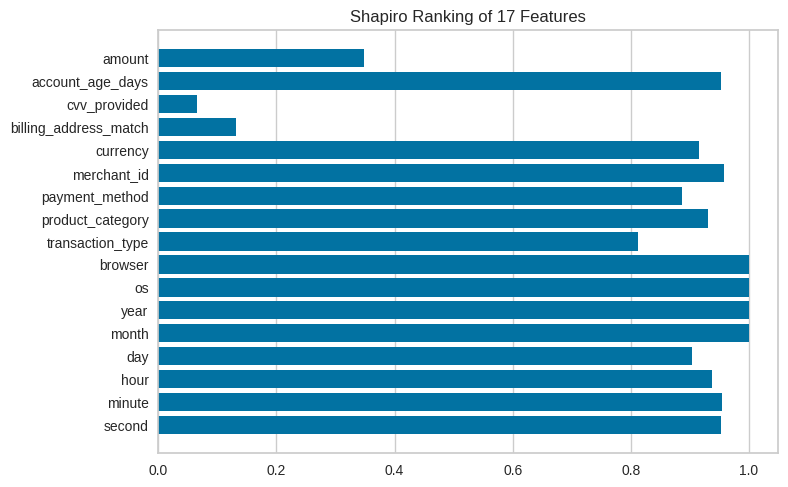

✓ (0.62s)
[2/6] |██████░░░░░░░░░░░░░░| Rank2D... 

/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


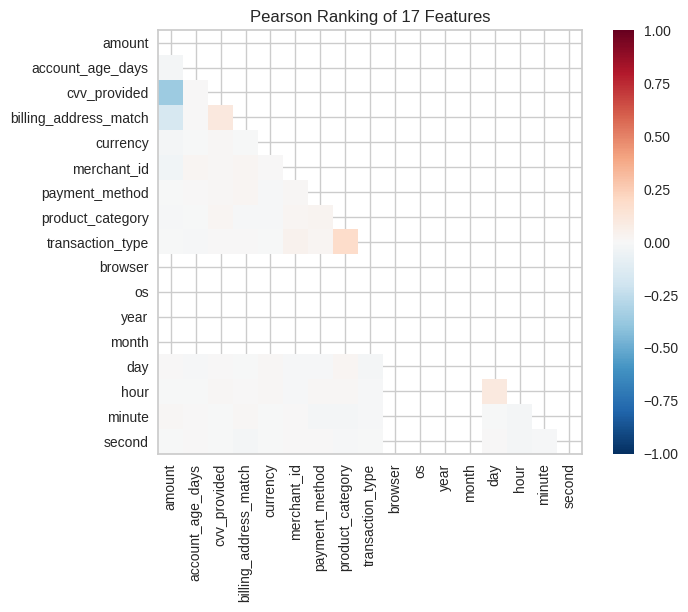

✓ (0.83s)
[3/6] |██████████░░░░░░░░░░| PCA... 

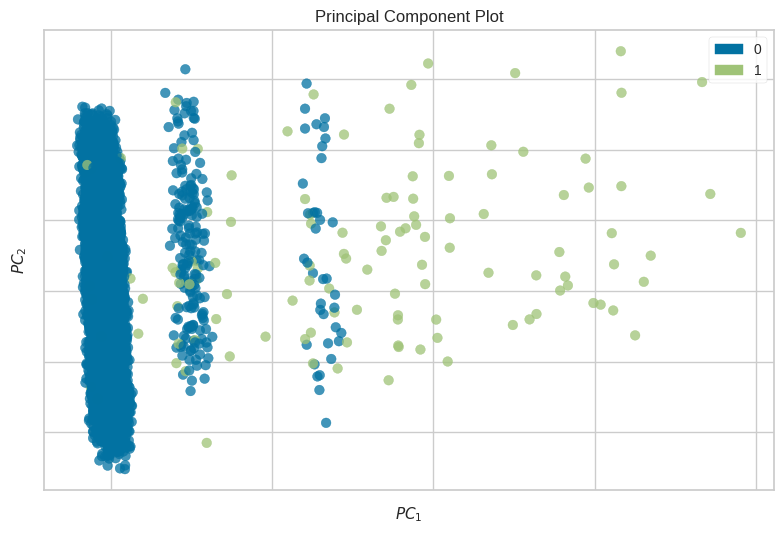

✓ (2.45s)
[4/6] |█████████████░░░░░░░| ParallelCoordinates... 

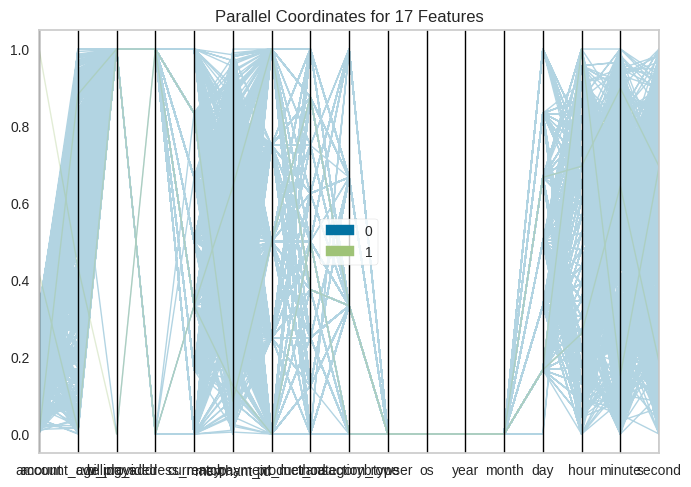

✓ (1.24s)
[5/6] |████████████████░░░░| RadViz... 

/home/rafaelcoelho/Workbench/COELHORealTime/notebooks/.venv/lib/python3.13/site-packages/yellowbrick/features/radviz.py:134: RuntimeWarning: invalid value encountered in divide
  return (X - a[np.newaxis, :]) / ((b - a)[np.newaxis, :])


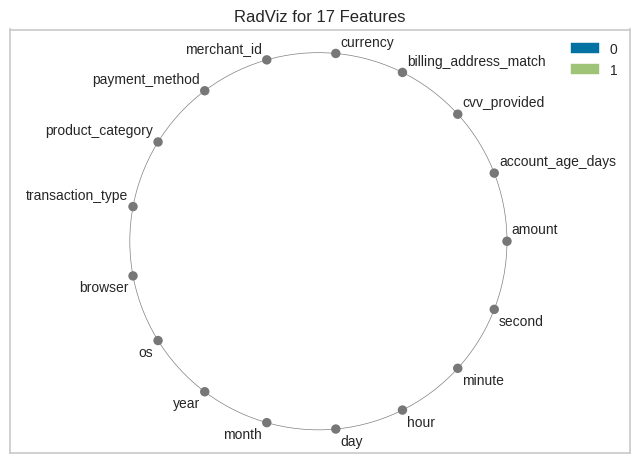

✓ (1.29s)
[6/6] |████████████████████| JointPlot... 

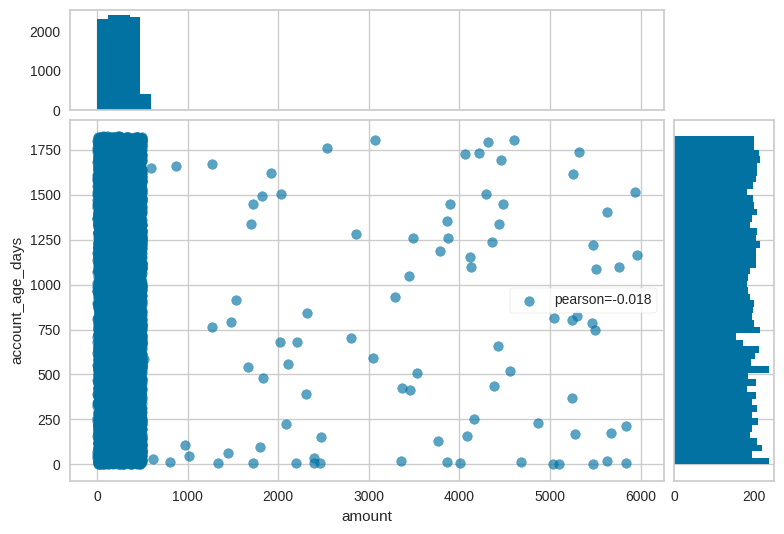

✓ (2.61s)

+========================================================================+
|                                SUMMARY                                 |
+========================================================================+
| Completed:      2026-01-18 16:49:42                                     |
| Total time:     9.05 seconds                                            |
| Successful:     6/6 visualizers                                         |
+------------------------------------------------------------------------+
|                            TIMING BREAKDOWN                            |
+------------------------------------------------------------------------+
| ✓ JointPlot                 |▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|     2.61s |
| ✓ PCA                       |▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓░░|     2.45s |
| ✓ RadViz                    |▓▓▓▓▓▓▓▓▓░░░░░░░░░░░|     1.29s |
| ✓ ParallelCoordinates       |▓▓▓▓▓▓▓▓▓░░░░░░░░░░░|     1.24s |
| ✓ Rank2D                    |▓▓▓▓▓▓░░░░░░░░░░░░░░

In [38]:
# Run all feature analysis visualizers
# Data is already numeric from DuckDB SQL - no conversion needed!

# Combine train+test for feature analysis (more data = better visualizations)
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

print(f"Data ready for YellowBrick: {X_full.shape[0]:,} samples x {X_full.shape[1]} features")
print(f"All numeric: {X_full.select_dtypes(include=['number']).shape[1]}/{X_full.shape[1]} columns")

# Run visualizers
results = yellowbrick_feature_analysis_visualizers(
    feature_analysis_kwargs,
    X_full,
    y_full,
    YELLOWBRICK_PATH,
    verbose=True,
)